In [210]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

from scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from gurobi_optimods.qubo import solve_qubo

In [211]:
backend = AerSimulator()

In [212]:
def convert_qubo_to_ising(qubo):
    # Number of qubits
    n = len(qubo)

    # Calculate the offset also, this is not important for the QAOA optimization
    offset = 0
    
    operator_list = []

    for i in range(n):
        for j in range(i, n):
            # Initialize the Pauli operator with all I's
            pauli_operator = list("I"*n)
            
            if i == j:
                pauli_operator[i] = "Z"
                ising_value = -(1/2)*np.sum(qubo[i])
            else:
                pauli_operator[i] = "Z"
                pauli_operator[j] = "Z"
                ising_value = (1/2)*qubo[i][j]

            if not ising_value == 0:
                ising_pauli_op = (''.join(pauli_operator), ising_value)
                operator_list.append(ising_pauli_op)

            offset += (1/2)*qubo[i][j]

    operators = SparsePauliOp.from_list(operator_list)

    return operators, offset

In [213]:
def initialize_qaoa(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.barrier()

    return qc

In [214]:
# Add a cost layer based on the Ising Hamiltonian
def add_cost_layer(qc, ising, gamma, n):
    cost_layer = PauliEvolutionGate(ising, gamma)
    qc.append(cost_layer, range(n))
    qc.barrier()

In [215]:
# Add a QAOA mixer layer
def add_mixer_layer(qc, beta, n):
    qc.rx(2*beta, range(n))
    qc.barrier()

In [216]:
def add_qaoa_layer(qc, ising, parameters, layers, n):
    i = 0
    while i < layers*2:
        # Apply cost layer
        add_cost_layer(qc, ising, parameters[i], n)

        # Apply mixer layer
        add_mixer_layer(qc, parameters[i+1], n)

        # Move to next QAOA layer
        i += 2

In [217]:
def initialize_parameters(layers):
    theta = []

    # Initialize a parameter for the "gamma" and "beta" variables
    initial_gamma = 2 * np.pi
    initial_beta = np.pi
    
    initial_param_list = [initial_gamma, initial_beta] * layers
    theta.extend(initial_param_list)
    
    return theta

In [218]:
# Calculate the expectation value using the QUBO matrix. We are trying to minimize this expectation value.
def calculate_expectation_value(theta, qc, qubo, parameters, exp_value_list, shots=10000):
    # Assign the gammas and the betas to the circuit
    qc_assigned_parameters = qc.assign_parameters({parameters:theta})
    # Transpile the circuit for the backend and measure the qubits
    qc_assigned_parameters.measure_all()
    qc_transpiled = transpile(qc_assigned_parameters, backend)

    # Run the circuit on the backend
    result = backend.run(qc_transpiled, shots=shots).result()

    # Save the counts to a variable
    counts = result.get_counts()

    exp_value = 0

    for bitstring in counts.keys():
        # Calculate the occurrence of a bitstring with respect to the number of shots
        occurrence_bitstring = counts[bitstring] / shots

        # Calculate the QUBO result of a bitstring
        qubo_value = 0
        for i in range(len(qubo)):
            for j in range(len(qubo)):
                if i == j:
                    qubo_value += qubo[i][j]*int(bitstring[i])
                else:
                    qubo_value += qubo[i][j]*int(bitstring[i])*int(bitstring[j])

        # Expectation values of all bitstrings are summed
        exp_value += occurrence_bitstring * qubo_value
    
    exp_value_list.append(exp_value)
    
    return exp_value


In [219]:
def optimize_parameters(qc, qubo, parameters, theta):
    # Save the expectation values the optimization gives us so that we can visualize the optimization
    exp_value_list = []

    min_minimized_optimization = minimize(calculate_expectation_value, theta, method="Powell", args=(qc, qubo, parameters, exp_value_list))

    # Save the objective value the optimization finally gives us
    minimum_objective_value = min_minimized_optimization.fun
    min_exp_value_list = exp_value_list

    return min_minimized_optimization.x, minimum_objective_value, min_exp_value_list

In [220]:
def qaoa(qubo, layers):
    # Number of qubits = length of the QUBO matrix
    n = len(qubo)

    # Initialize circuit
    qc = initialize_qaoa(n)

    # Initialize parameters
    parameters = ParameterVector('theta', 2*layers)
    theta = initialize_parameters(layers)

    # Convert the QUBO matrix to the Ising Hamiltonian
    ising, offset = convert_qubo_to_ising(qubo)

    # Apply the QAOA layers
    add_qaoa_layer(qc, ising, parameters, layers, n)

    # Optimize the parameters
    theta, minimum_objective_value, exp_value_list = optimize_parameters(qc, qubo, parameters, theta)

    return qc, theta, minimum_objective_value, exp_value_list, parameters

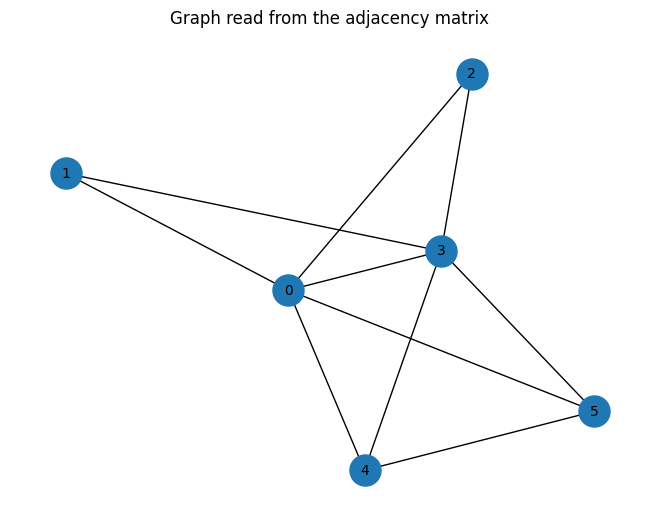

In [221]:
# Define MaxCut problem with an adjacency matrix and turn it into a QUBO matrix

adjacency_matrix = [[0, 1, 1, 1, 1, 1],
                    [1, 0, 0, 1, 0, 0],
                    [1, 0, 0, 1, 0, 0],
                    [1, 1, 1, 0, 1, 1],
                    [1, 0, 0, 1, 0, 1],
                    [1, 0, 0, 1, 1, 0]]

#adjacency_matrix = [[0, 1, 1, 1, 1, 1],
#                    [1, 0, 1, 1, 1, 1],
#                    [1, 1, 0, 1, 1, 1],
#                    [1, 1, 1, 0, 1, 1],
#                    [1, 1, 1, 1, 0, 1],
#                    [1, 1, 1, 1, 1, 0]]

#adjacency_matrix = [[0, 1, 0, 1, 0, 0, 0, 0],
#                    [1, 0, 1, 1, 0, 0, 0, 0],
#                    [0, 1, 0, 0, 0, 0, 1, 0],
#                    [1, 1, 0, 0, 0, 1, 0, 0],
#                    [0, 0, 0, 0, 0, 1, 0, 0],
#                    [0, 0, 0, 1, 1, 0, 0, 0],
#                    [0, 0, 1, 0, 0, 0, 0, 1],
#                    [0, 0, 0, 0, 0, 0, 1, 0]]

#adjacency_matrix = [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]]

graph = nx.Graph()
vertex_number = len(adjacency_matrix)
vertex_list = []
for i in range(vertex_number):
    vertex_list.append(i)
    for j in range(vertex_number):
        if adjacency_matrix[i][j] == 1:
            graph.add_edge(i, j)

num_nodes = graph.number_of_nodes()
qubo = np.eye(num_nodes)

for i in range(len(adjacency_matrix[0])):
    sum = 0
    for j in range(len(adjacency_matrix[0])):
        sum = sum + adjacency_matrix[i][j]
        if adjacency_matrix[i][j] == 1 and not i == j:
            qubo[i][j] = 1
    qubo[i][i] = -sum

edge_list = list(graph.edges())
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True, node_size=500, font_size=10)
plt.title("Graph read from the adjacency matrix")
plt.show()

In [222]:
# Run the QAOA and define the number of layers
qc, theta, minimum_objective_value, exp_value_list, parameters = qaoa(qubo, 2)

In [223]:
print("Result:", minimum_objective_value)

Result: -6.6713000000000005


In [224]:
print("Result with a classical solver: ", solve_qubo(qubo))

New QUBO solution found with objective 0.0
New QUBO solution found with objective -8.0
Result with a classical solver:  QuboResult(solution=array([1., 0., 0., 1., 0., 0.]), objective_value=-8.0)


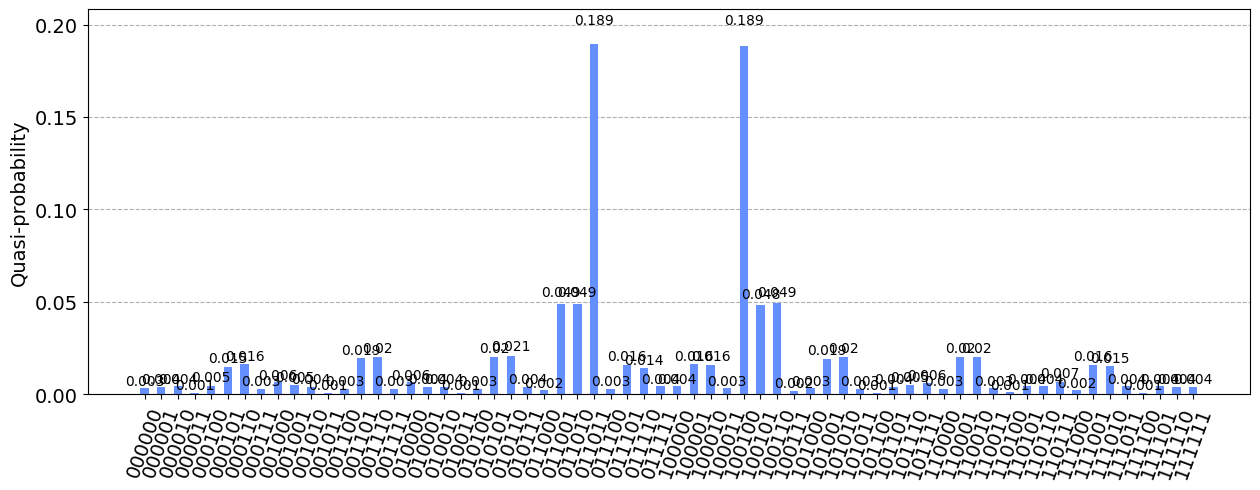

In [225]:
qc_assigned_parameters = qc.assign_parameters({parameters:theta})
qc_transpiled = transpile(qc_assigned_parameters, backend=backend)
qc_transpiled.measure_all()

counts = backend.run(qc_transpiled, shots=50000).result().get_counts()

plot_distribution(counts, figsize=(15, 5))

In [226]:
highest_possible_solution = 0
max_count = 0
for key, count in counts.items():
    if count > max_count:
        max_count = count
        highest_possible_solution = key
print(f"Highest possible solution: {highest_possible_solution}")

# Convert string to array
X = np.fromstring(highest_possible_solution, np.int8) - 48

# Calculate the result using the highest possible solution
E = X.T @ Q @ X

print(f"Result: {E}")

Highest possible solution: 011011
Result: -8.0


C:\Users\tpihkako19\AppData\Local\Temp\ipykernel_16216\1529694762.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  X = np.fromstring(highest_possible_solution, np.int8) - 48


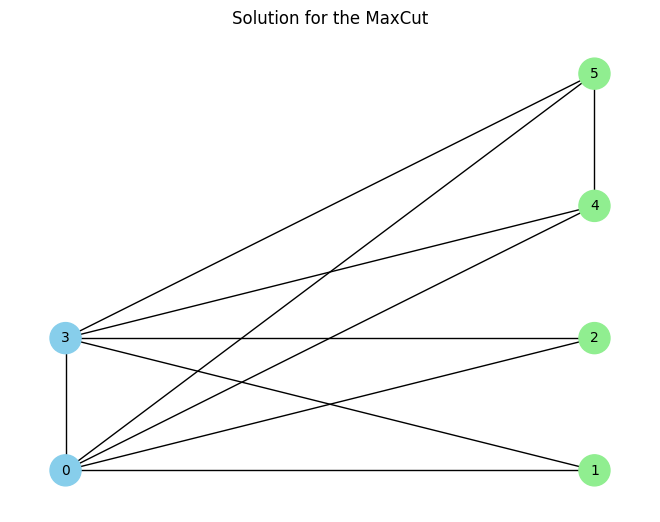

In [227]:
graph = nx.Graph()
group_1 = []
group_2 = []
vertex_number = len(highest_possible_solution)
for i in range(vertex_number):
    if highest_possible_solution[i] == "0":
        group_1.append(i)
    elif highest_possible_solution[i] == "1":
        group_2.append(i)
    else:
        print("No valid solution")
graph.add_nodes_from(group_1, bipartite=0)
graph.add_nodes_from(group_2, bipartite=1)
graph.add_edges_from(edge_list)
pos = {}
pos.update((n, (1, i)) for i, n in enumerate(group_1))
pos.update((n, (2, i)) for i, n in enumerate(group_2))
nx.draw(graph, pos, with_labels=True, node_size=500, font_size=10, node_color=['skyblue'] * len(group_1) + ['lightgreen'] * len(group_2))
plt.title("Solution for the MaxCut")
plt.show()